In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 【課題1】練習のために特徴量とカテゴリを選択

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = pd.DataFrame(data.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
y = pd.DataFrame(data.target, columns=['Species'])
df = pd.concat([X, y], axis=1)

df_selected = df.query('Species in [1, 2]')[['sepal_length', 'petal_length', 'Species']]

## 【問題2】データの分析

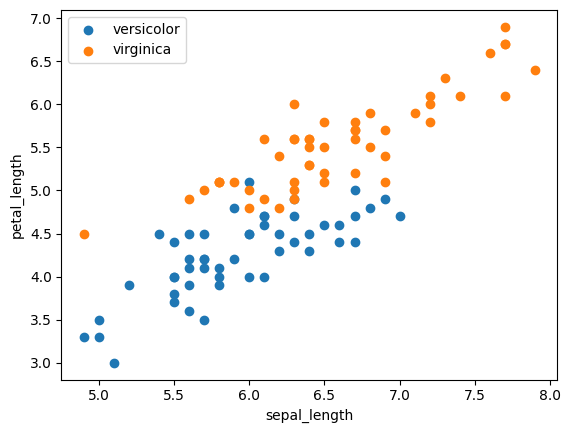

In [3]:
# 散布図
for i in [1, 2]:
    plt.scatter(df_selected.query(f'Species == {i}')['sepal_length'],
                df_selected.query(f'Species == {i}')['petal_length'],
                label=data.target_names[i])
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

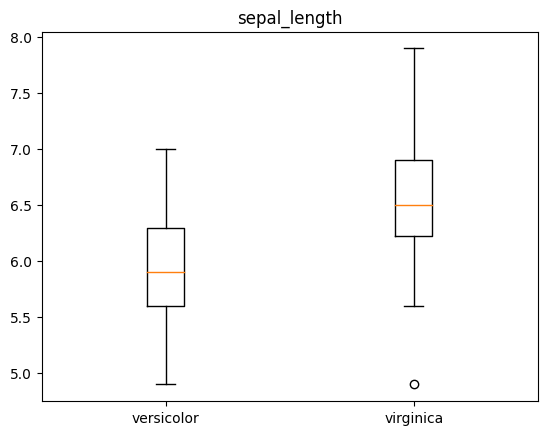

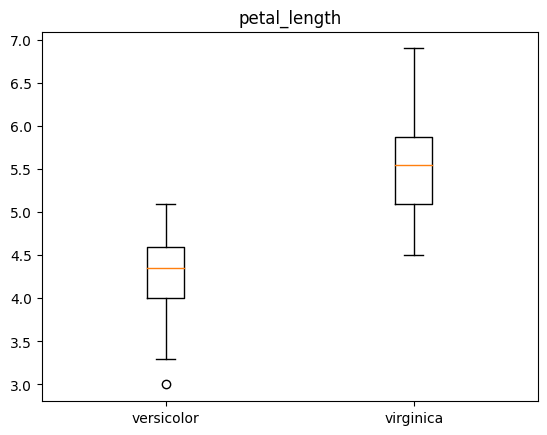

In [4]:
# 箱ひげ図
for feature in df_selected.columns[:-1]:
    plt.boxplot([df_selected.query(f'Species == {i}')[feature] for i in [1, 2]])
    plt.title(feature)
    plt.xticks([1, 2], data.target_names[[1, 2]])
    plt.show()

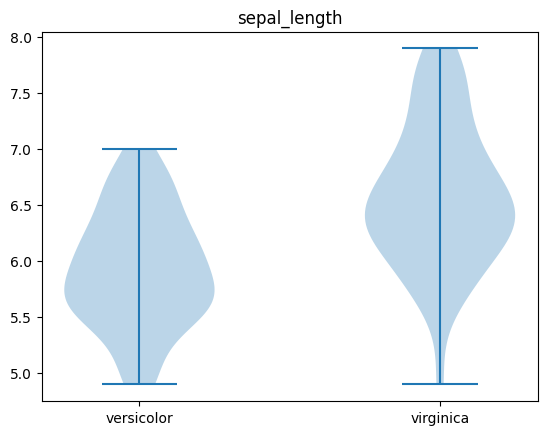

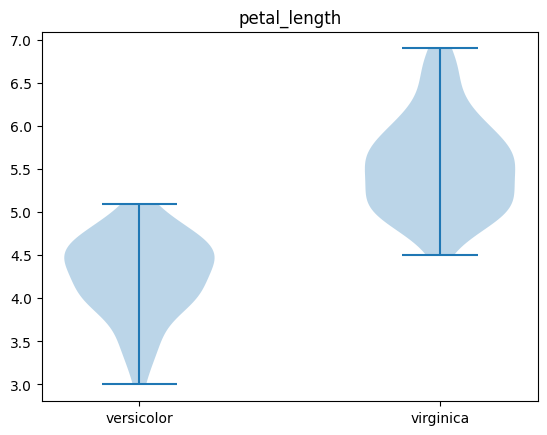

In [5]:
# バイオリン図
for feature in df_selected.columns[:-1]:
    plt.violinplot([df_selected.query(f'Species == {i}')[feature] for i in [1, 2]])
    plt.title(feature)
    plt.xticks([1, 2], data.target_names[[1, 2]])
    plt.show()

## 【問題3】前処理・訓練データと検証データの分割

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_selected.iloc[:,:-1], df_selected.iloc[:,-1], test_size=0.25, random_state=42)

## 【問題4】前処理・標準化

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 【問題5】学習と推定

In [8]:
from sklearn.neighbors import KNeighborsClassifier

models, predicted = {}, {}

for i in [1, 3, 5]:
    key = f'{i}-nn'
    
    models[key] = KNeighborsClassifier(n_neighbors=i)
    models[key].fit(X_train_scaled, y_train)
    predicted[key] = models[key].predict(X_test_scaled)
    
    print(f'{key}: {predicted[key]}')

1-nn: [2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 2]
3-nn: [2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 2]
5-nn: [2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2]


## 【問題6】評価

In [9]:
from sklearn import metrics

def evaluate(y_true, y_pred, title):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    confusion = metrics.confusion_matrix(y_true, y_pred)
    
    print(    
        f'--- {title} ---',
        f'accuracy:  {accuracy}',
        f'precision: {precision}',
        f'recall:    {recall}',
        f'f1:        {f1}',
        f'confusion matrix:\n{confusion}\n',
        sep='\n'
    )

for key in predicted.keys():
    evaluate(y_test, predicted[key], key)

--- 1-nn ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]

--- 3-nn ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]

--- 5-nn ---
accuracy:  0.8
precision: 0.7647058823529411
recall:    0.9285714285714286
f1:        0.8387096774193549
confusion matrix:
[[13  1]
 [ 4  7]]



**4種類の指標値の意味について簡単に調査して文章でまとめる**

正解率：全ての予測に対して正解したものの割合。

適合率：正と予測したデータのうち，実際に正であるものの割合。

再現率：実際に正であるもののうち，正であると予測されたものの割合。

F値：適合率と再現率の調和平均であり、両者をバランスよく評価するための指標。

## 【問題7】可視化

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(np.unique(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

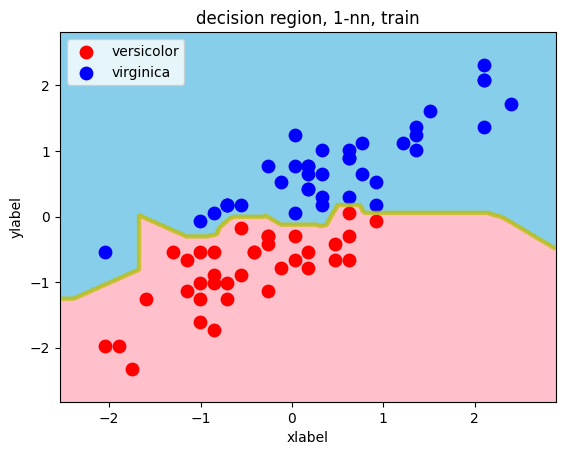

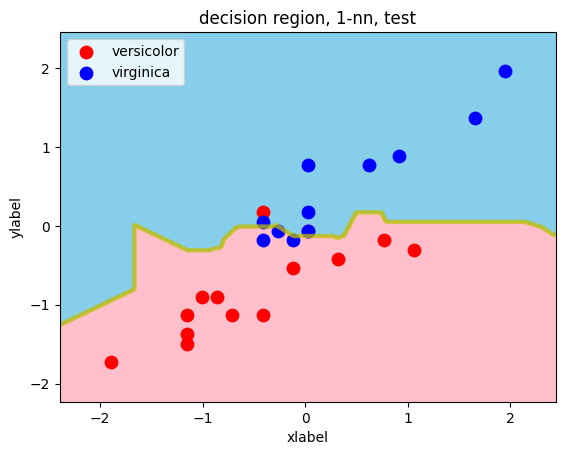

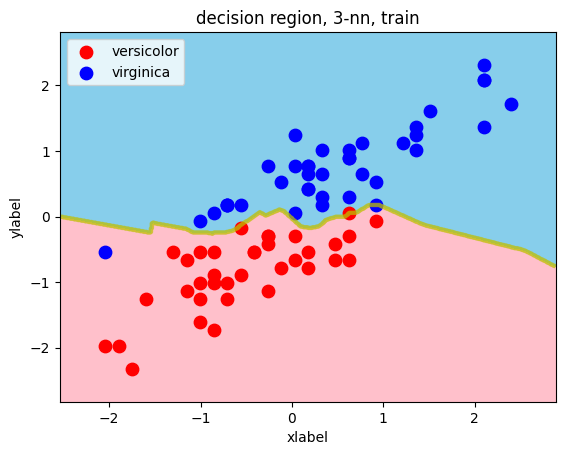

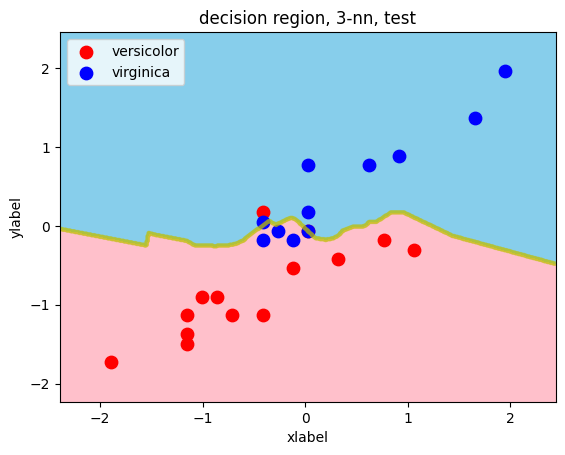

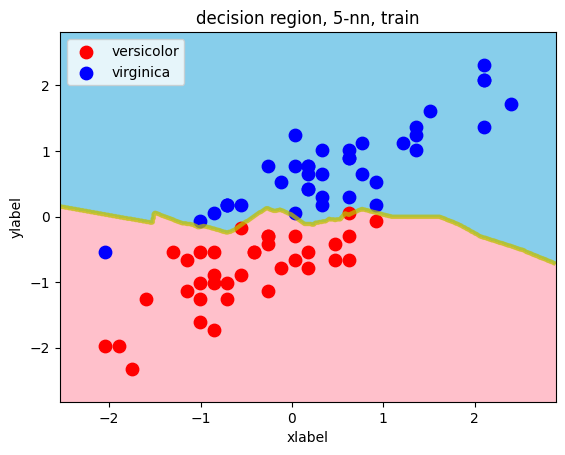

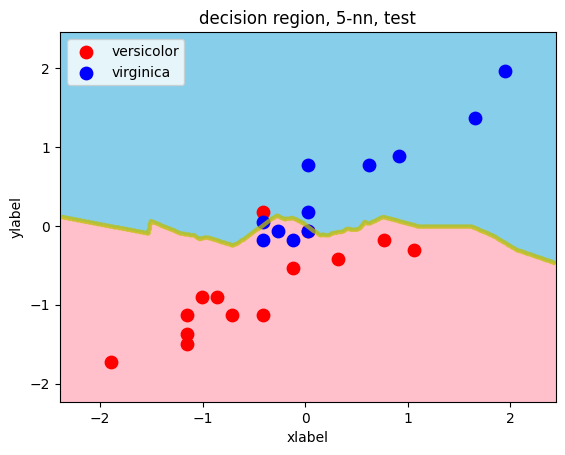

In [11]:
for key in models.keys():
    decision_region(X_train_scaled, y_train, models[key], title=f'decision region, {key}, train')
    decision_region(X_test_scaled,  y_test,  models[key], title=f'decision region, {key}, test')

## 【問題8】他の手法の学習

--- 1-nn ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]



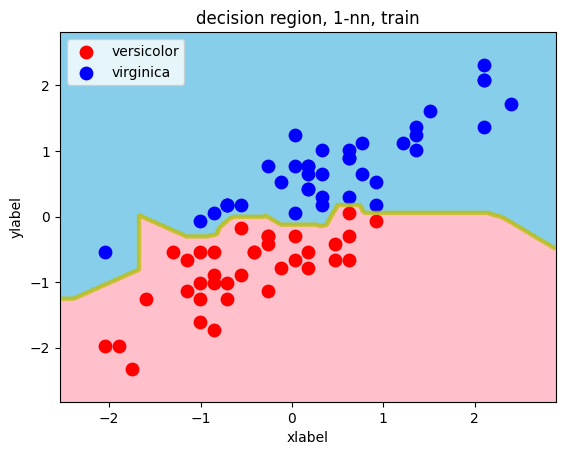

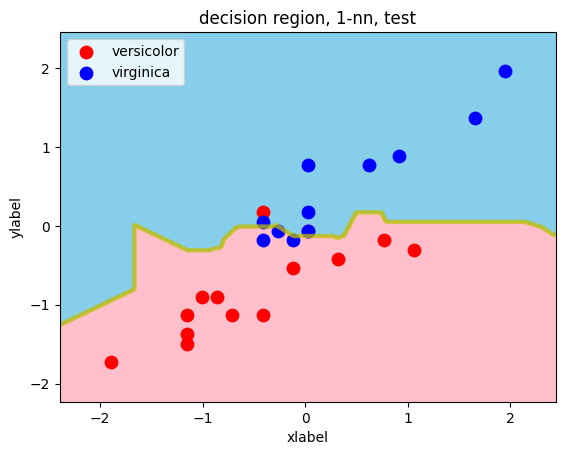

--- 3-nn ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]



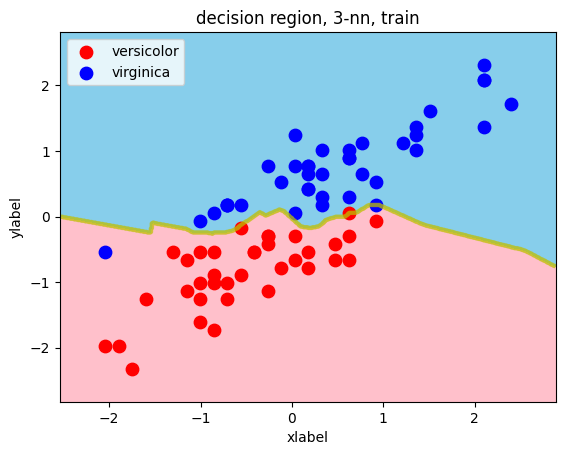

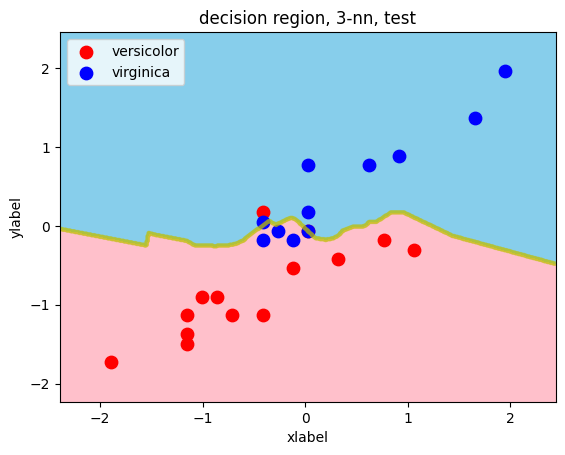

--- 5-nn ---
accuracy:  0.8
precision: 0.7647058823529411
recall:    0.9285714285714286
f1:        0.8387096774193549
confusion matrix:
[[13  1]
 [ 4  7]]



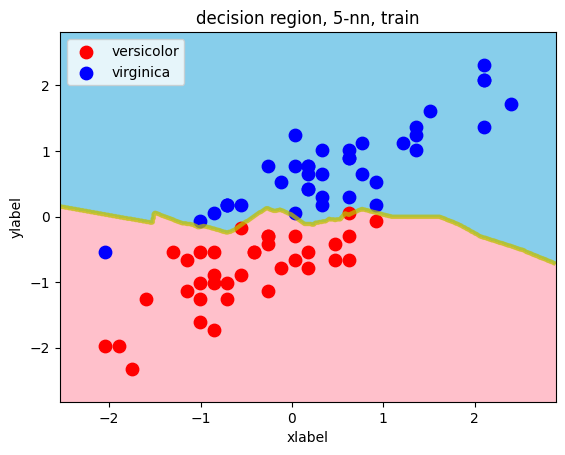

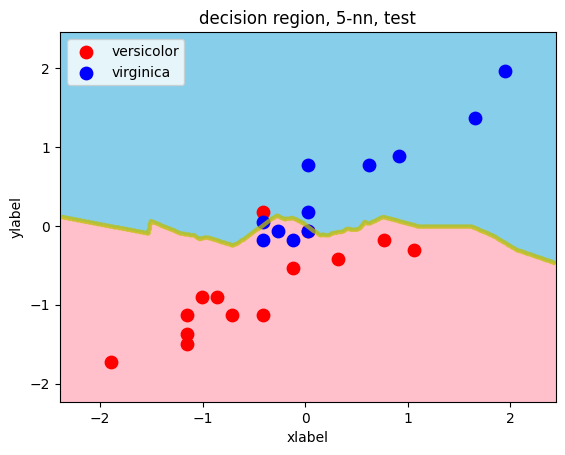

--- Logistic Regression ---
accuracy:  0.84
precision: 0.8571428571428571
recall:    0.8571428571428571
f1:        0.8571428571428571
confusion matrix:
[[12  2]
 [ 2  9]]



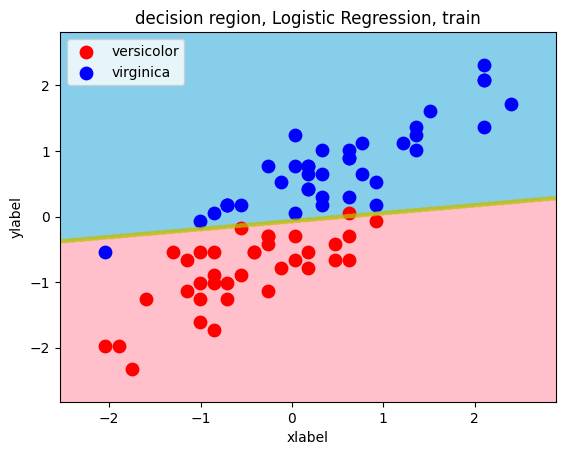

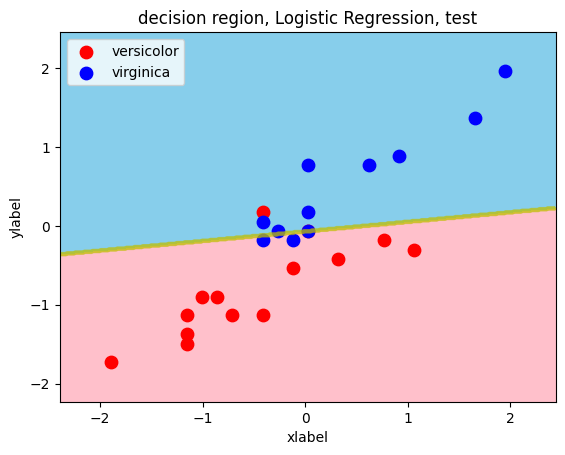

--- SVM ---
accuracy:  0.84
precision: 0.8571428571428571
recall:    0.8571428571428571
f1:        0.8571428571428571
confusion matrix:
[[12  2]
 [ 2  9]]



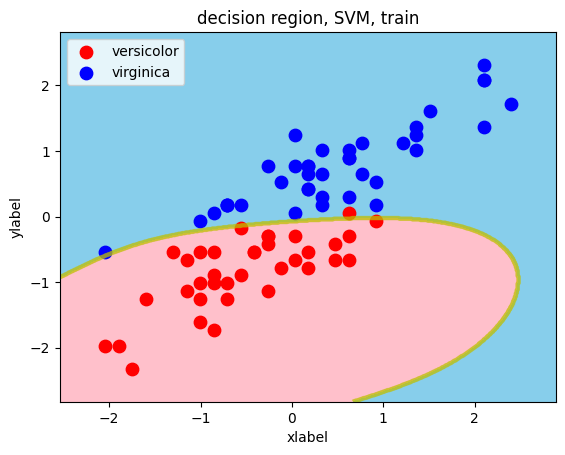

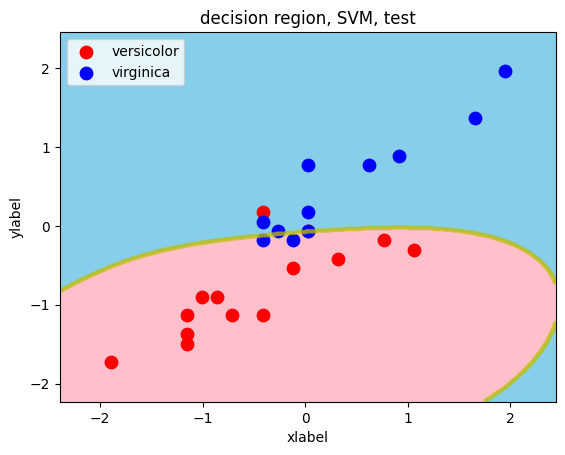

--- Decision Tree ---
accuracy:  0.84
precision: 0.8125
recall:    0.9285714285714286
f1:        0.8666666666666666
confusion matrix:
[[13  1]
 [ 3  8]]



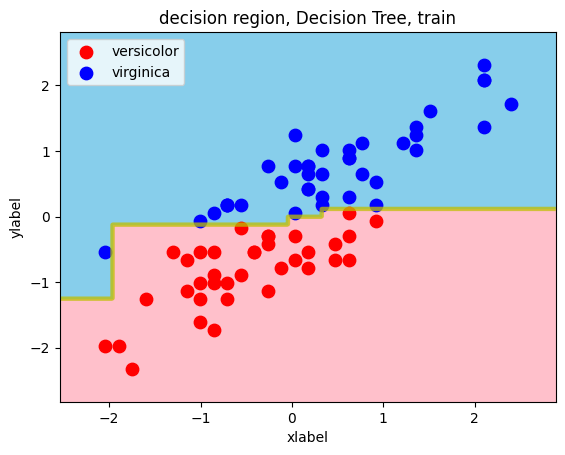

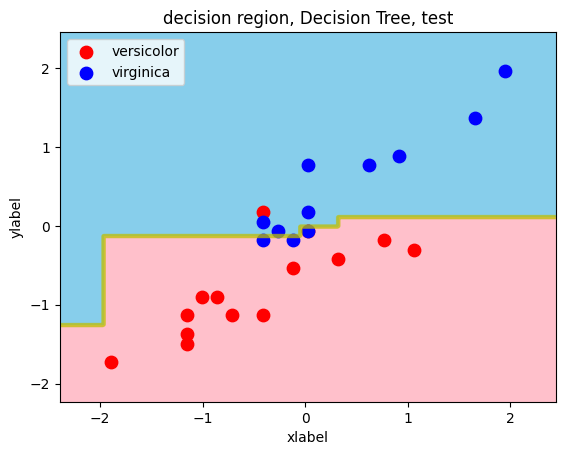

--- Random Forest ---
accuracy:  0.84
precision: 0.8125
recall:    0.9285714285714286
f1:        0.8666666666666666
confusion matrix:
[[13  1]
 [ 3  8]]



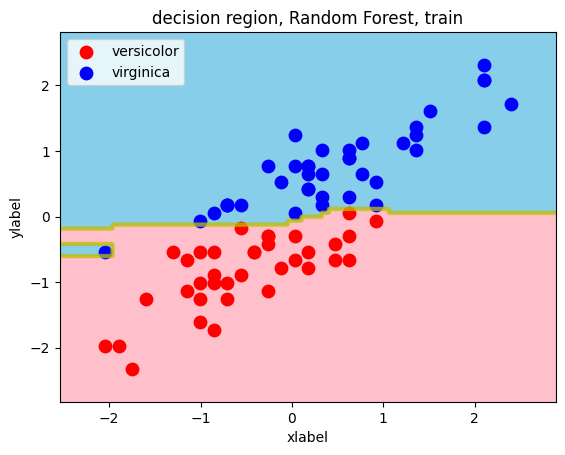

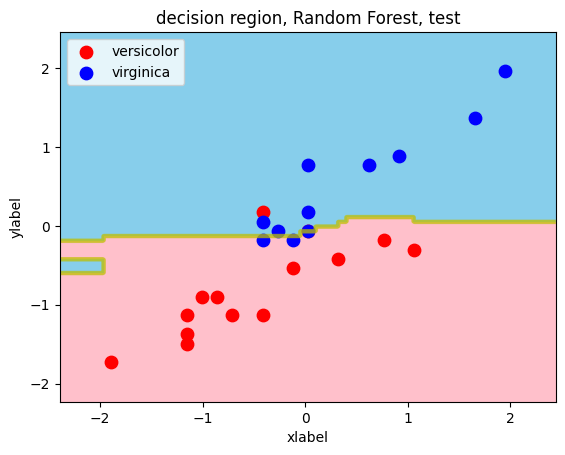

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model_dict = {
    '1-nn': KNeighborsClassifier(n_neighbors=1),
    '3-nn': KNeighborsClassifier(n_neighbors=3),
    '5-nn': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

for key in model_dict.keys():
    model_dict[key].fit(X_train_scaled, y_train)
    y_pred = model_dict[key].predict(X_test_scaled)
    
    evaluate(y_test, y_pred, key)
    decision_region(X_train_scaled, y_train, model_dict[key], title=f'decision region, {key}, train')
    decision_region(X_test_scaled,  y_test,  model_dict[key], title=f'decision region, {key}, test')

## 【問題9】（アドバンス課題）標準化の有無の比較

--- 1-nn, with standard scaling ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]



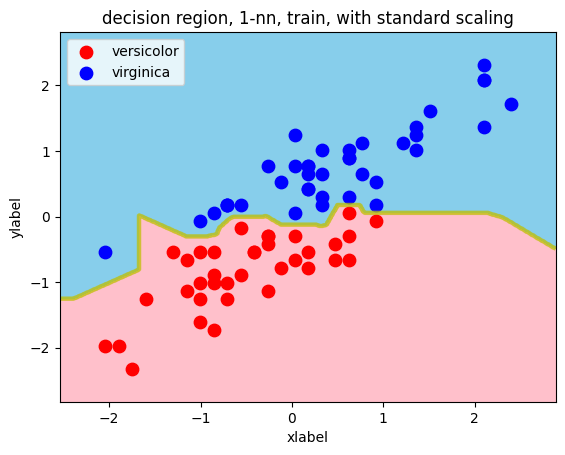

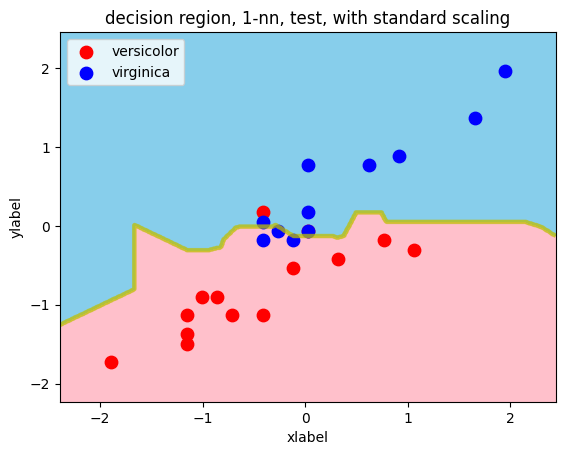

--- 1-nn, without standard scaling ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]



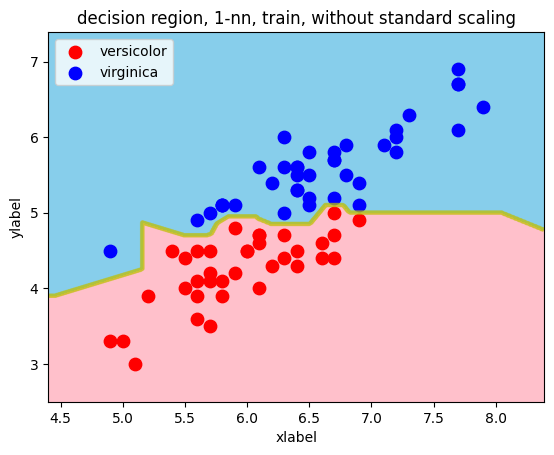

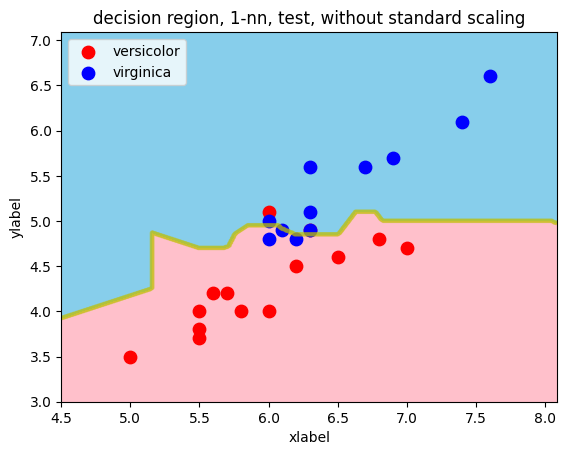

--- 3-nn, with standard scaling ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]



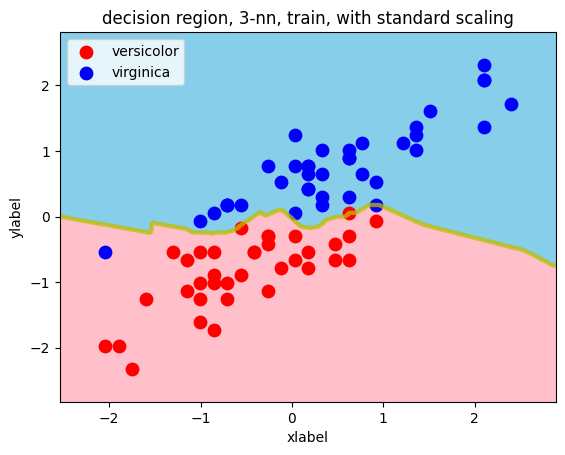

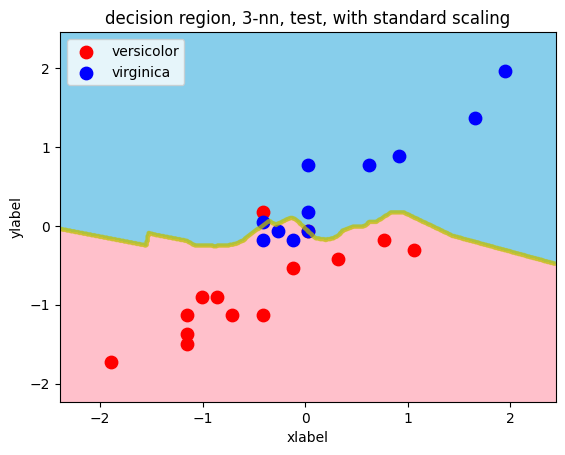

--- 3-nn, without standard scaling ---
accuracy:  0.8
precision: 0.8
recall:    0.8571428571428571
f1:        0.8275862068965518
confusion matrix:
[[12  2]
 [ 3  8]]



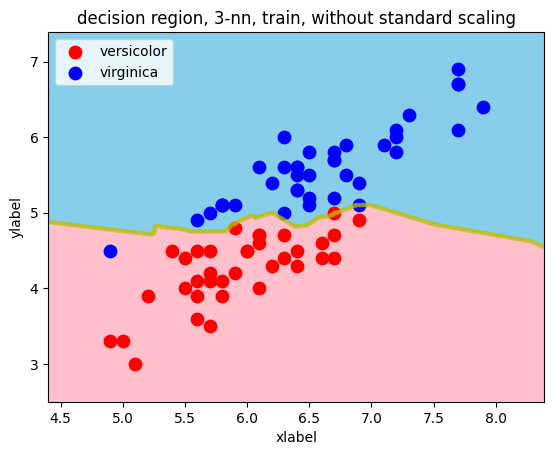

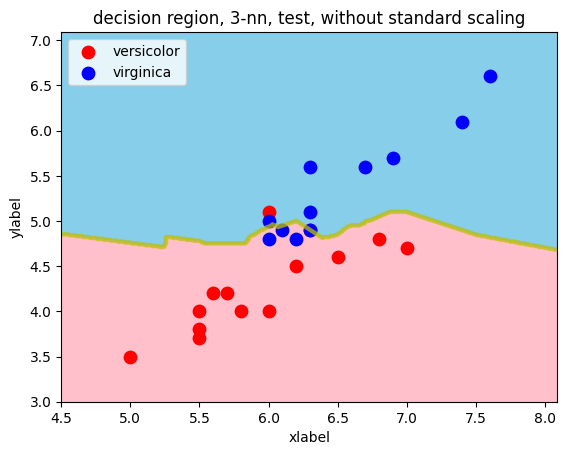

--- 5-nn, with standard scaling ---
accuracy:  0.8
precision: 0.7647058823529411
recall:    0.9285714285714286
f1:        0.8387096774193549
confusion matrix:
[[13  1]
 [ 4  7]]



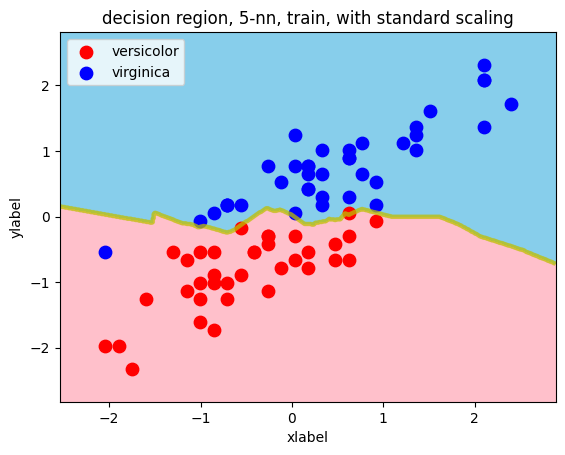

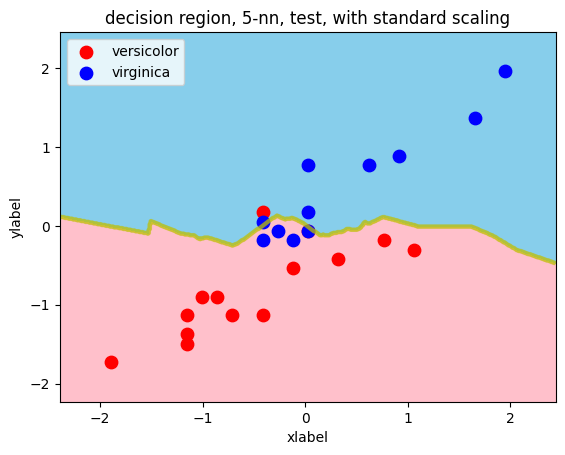

--- 5-nn, without standard scaling ---
accuracy:  0.8
precision: 0.7647058823529411
recall:    0.9285714285714286
f1:        0.8387096774193549
confusion matrix:
[[13  1]
 [ 4  7]]



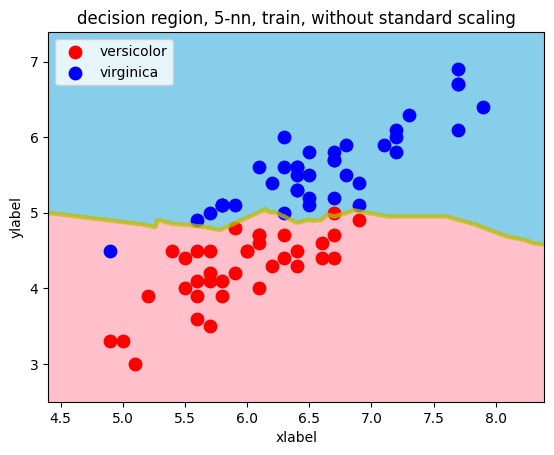

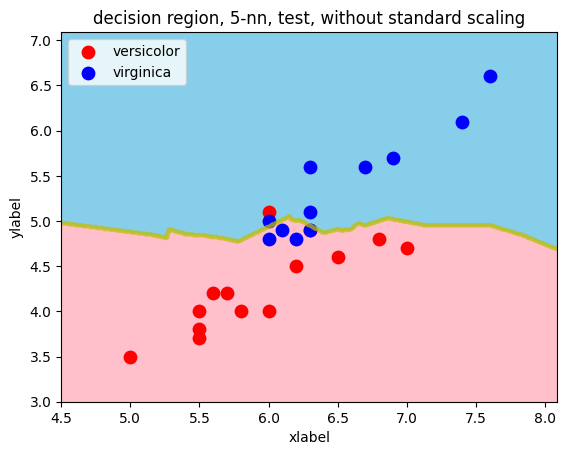

--- Logistic Regression, with standard scaling ---
accuracy:  0.84
precision: 0.8571428571428571
recall:    0.8571428571428571
f1:        0.8571428571428571
confusion matrix:
[[12  2]
 [ 2  9]]



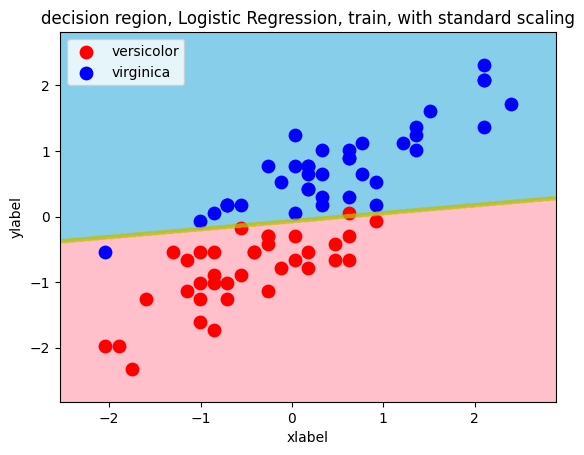

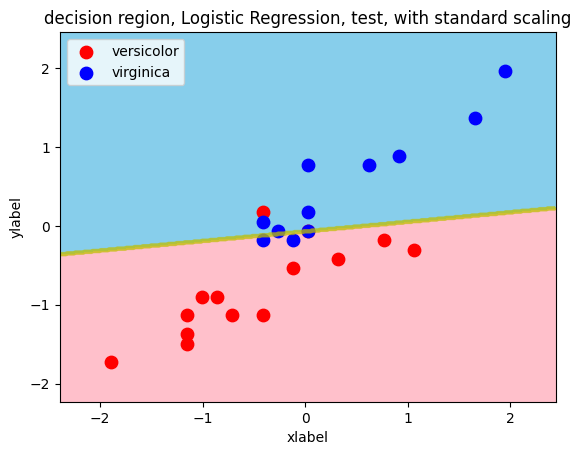

--- Logistic Regression, without standard scaling ---
accuracy:  0.84
precision: 0.8571428571428571
recall:    0.8571428571428571
f1:        0.8571428571428571
confusion matrix:
[[12  2]
 [ 2  9]]



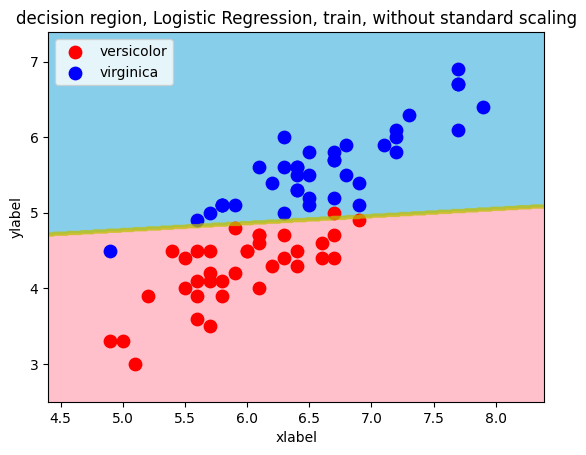

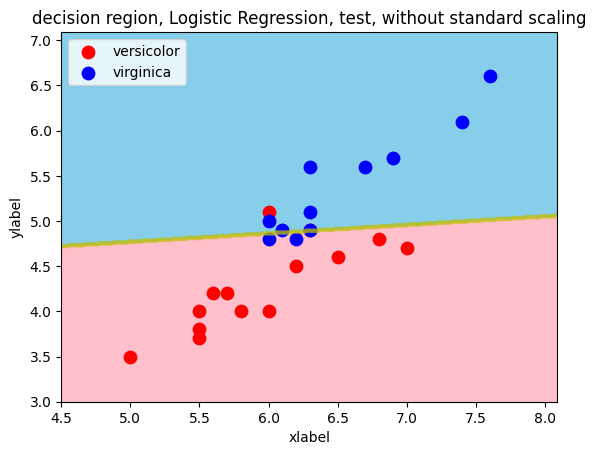

--- SVM, with standard scaling ---
accuracy:  0.84
precision: 0.8571428571428571
recall:    0.8571428571428571
f1:        0.8571428571428571
confusion matrix:
[[12  2]
 [ 2  9]]



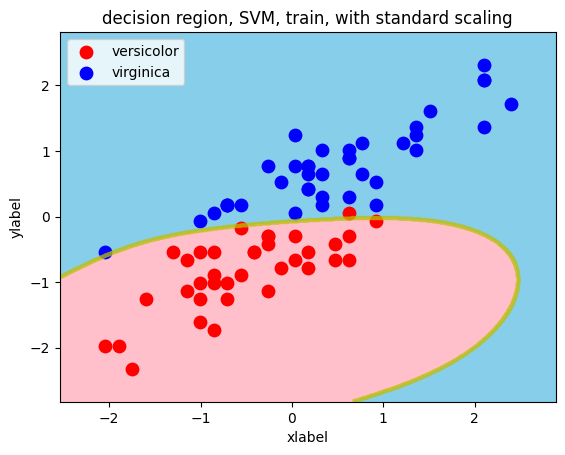

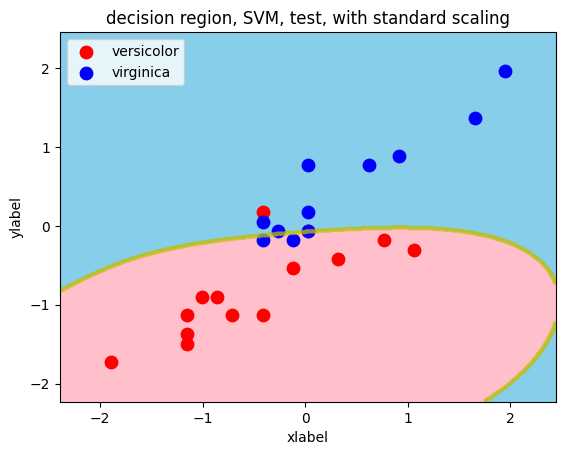

--- SVM, without standard scaling ---
accuracy:  0.84
precision: 0.8571428571428571
recall:    0.8571428571428571
f1:        0.8571428571428571
confusion matrix:
[[12  2]
 [ 2  9]]



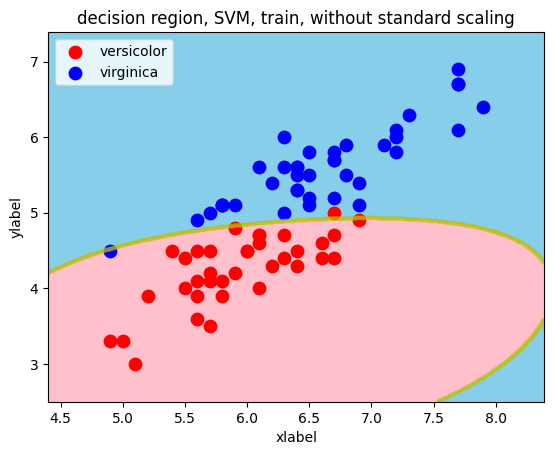

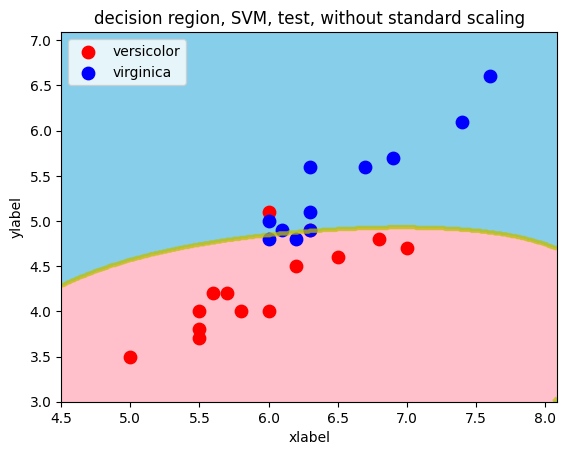

--- Decision Tree, with standard scaling ---
accuracy:  0.84
precision: 0.8125
recall:    0.9285714285714286
f1:        0.8666666666666666
confusion matrix:
[[13  1]
 [ 3  8]]



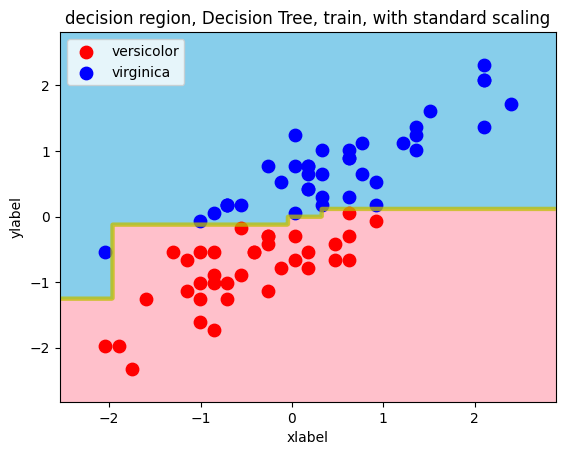

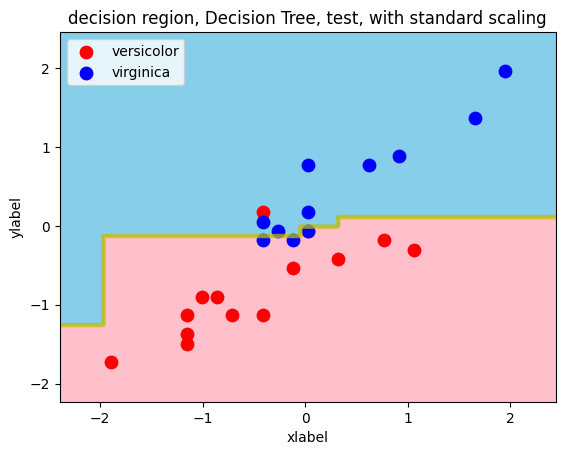

--- Decision Tree, without standard scaling ---
accuracy:  0.84
precision: 0.8125
recall:    0.9285714285714286
f1:        0.8666666666666666
confusion matrix:
[[13  1]
 [ 3  8]]



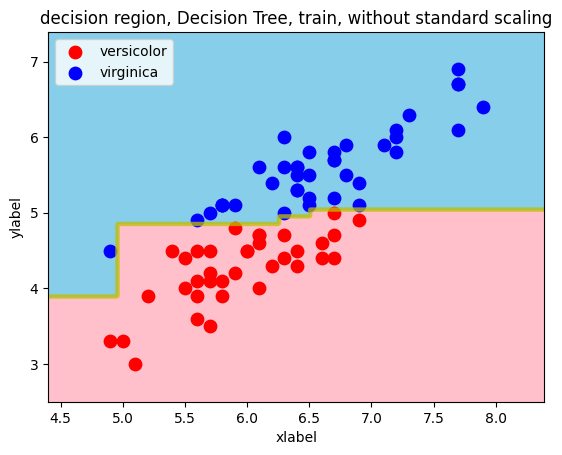

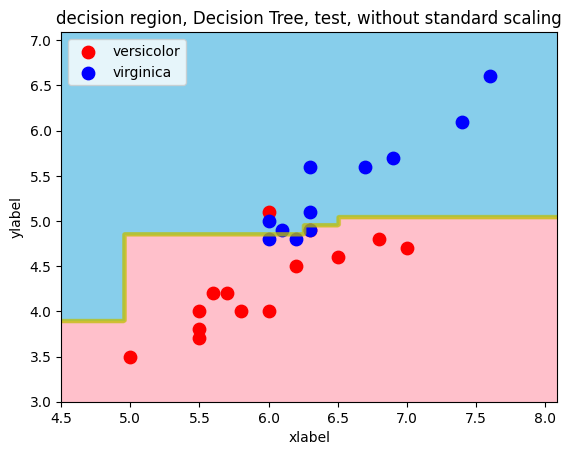

--- Random Forest, with standard scaling ---
accuracy:  0.84
precision: 0.8125
recall:    0.9285714285714286
f1:        0.8666666666666666
confusion matrix:
[[13  1]
 [ 3  8]]



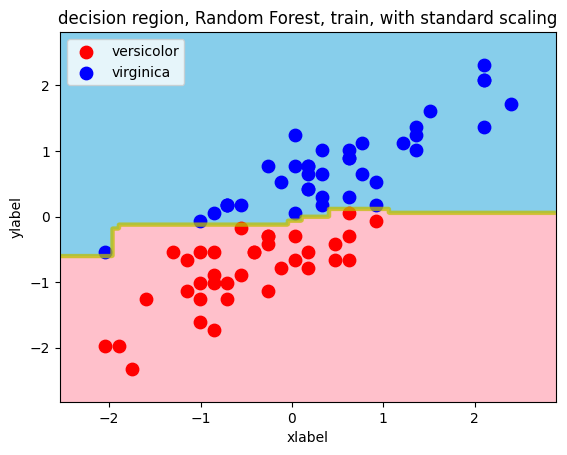

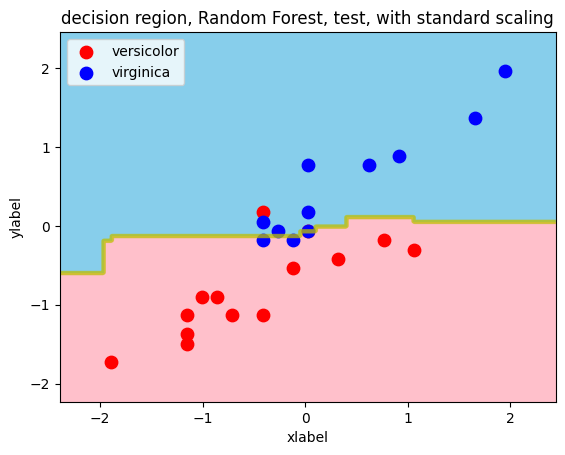

--- Random Forest, without standard scaling ---
accuracy:  0.84
precision: 0.8125
recall:    0.9285714285714286
f1:        0.8666666666666666
confusion matrix:
[[13  1]
 [ 3  8]]



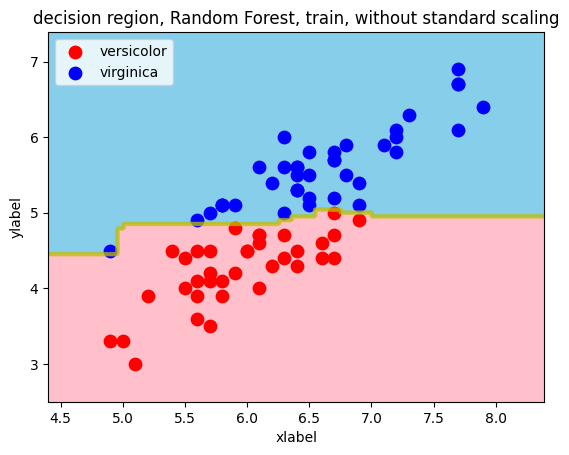

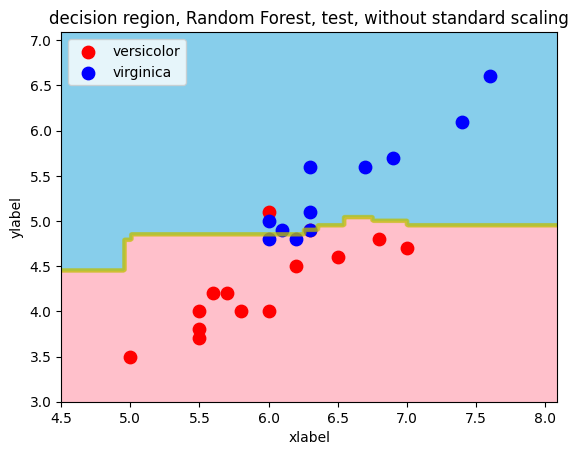

In [13]:
X_train_ndarray = np.array(X_train)
X_test_ndarray = np.array(X_test)

for key in model_dict.keys():
    model_dict[key].fit(X_train_scaled, y_train)
    y_pred = model_dict[key].predict(X_test_scaled)
    evaluate(y_test, y_pred, f'{key}, with standard scaling')
    decision_region(X_train_scaled, y_train, model_dict[key], 
                    title=f'decision region, {key}, train, with standard scaling')
    decision_region(X_test_scaled,  y_test,  model_dict[key], 
                    title=f'decision region, {key}, test, with standard scaling')
    
    model_dict[key].fit(X_train_ndarray, y_train)
    y_pred = model_dict[key].predict(X_test_ndarray)
    evaluate(y_test, y_pred, f'{key}, without standard scaling')
    decision_region(X_train_ndarray, y_train, model_dict[key], 
                    title=f'decision region, {key}, train, without standard scaling')
    decision_region(X_test_ndarray,  y_test,  model_dict[key], 
                    title=f'decision region, {key}, test, without standard scaling')

## 【問題10】（アドバンス課題）すべての目的変数を使用して精度が高い手法

In [14]:
df_selected2 = df[['sepal_length', 'petal_length', 'Species']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_selected2.iloc[:,:-1], df_selected2.iloc[:,-1], test_size=0.25, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train2)
X_train_scaled2 = scaler.transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

In [15]:
def evaluate2(y_true, y_pred, title):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average='macro')
    recall = metrics.recall_score(y_true, y_pred, average='macro')
    f1 = metrics.f1_score(y_true, y_pred, average='macro')
    confusion = metrics.confusion_matrix(y_true, y_pred)
    
    print(    
        f'--- {title} ---',
        f'accuracy:  {accuracy}',
        f'precision: {precision}',
        f'recall:    {recall}',
        f'f1:        {f1}',
        f'confusion matrix:\n{confusion}\n',
        sep='\n'
    )

In [16]:
def decision_region2(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue', 'green']
    contourf_color = ['pink', 'skyblue', 'lime']
    n_class = 3

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(np.unique(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

--- 1-nn ---
accuracy:  0.9210526315789473
precision: 0.9285714285714285
recall:    0.9166666666666666
f1:        0.9123809523809524
confusion matrix:
[[15  0  0]
 [ 0 11  0]
 [ 0  3  9]]



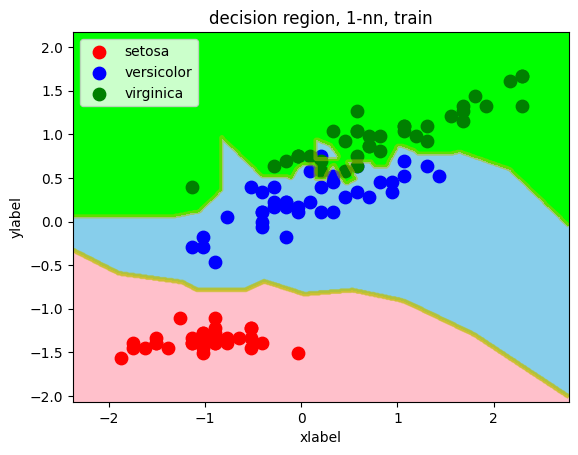

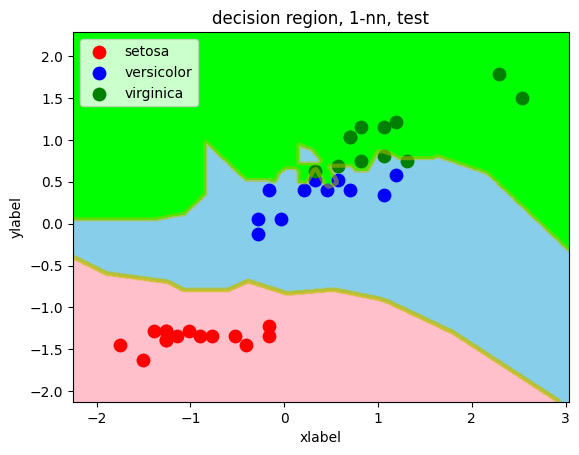

--- 3-nn ---
accuracy:  0.9473684210526315
precision: 0.9419191919191919
recall:    0.9419191919191919
f1:        0.9419191919191919
confusion matrix:
[[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]



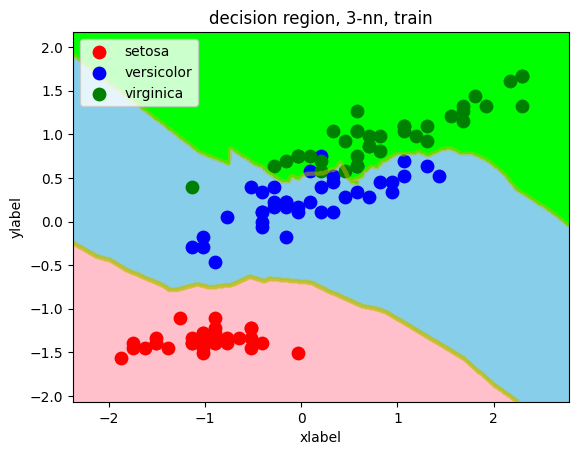

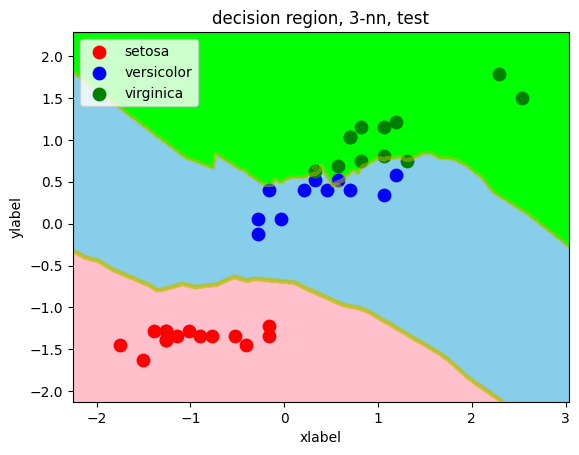

--- 5-nn ---
accuracy:  0.9473684210526315
precision: 0.9419191919191919
recall:    0.9419191919191919
f1:        0.9419191919191919
confusion matrix:
[[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]



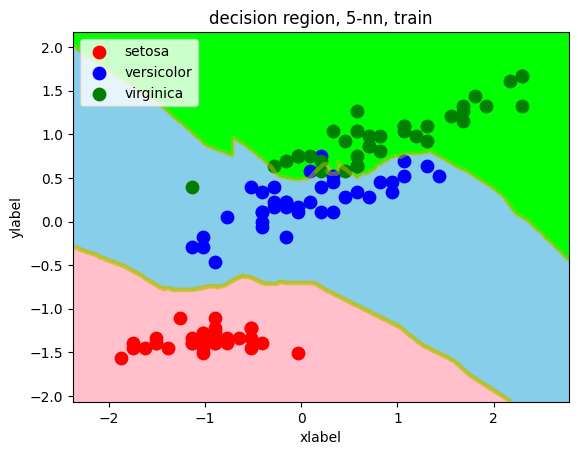

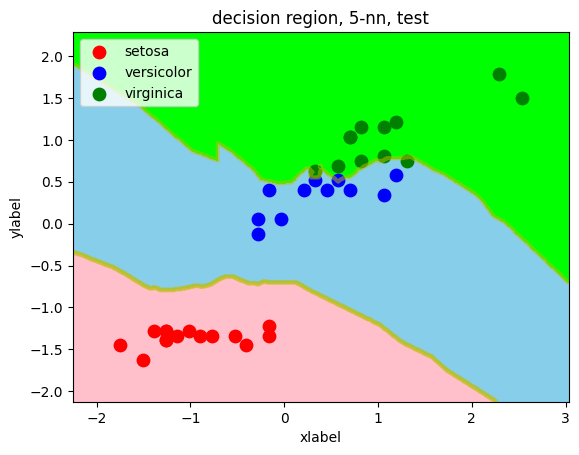

--- Logistic Regression ---
accuracy:  1.0
precision: 1.0
recall:    1.0
f1:        1.0
confusion matrix:
[[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]



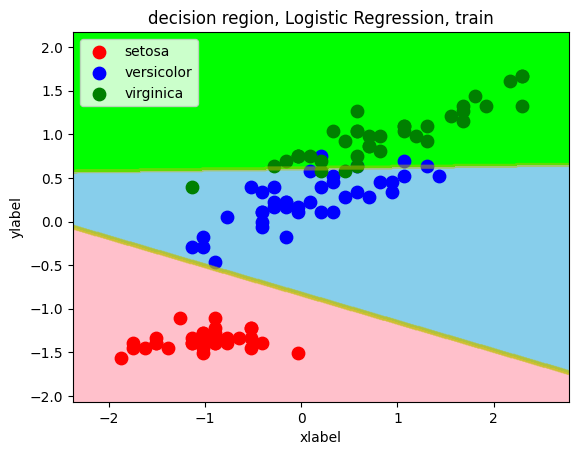

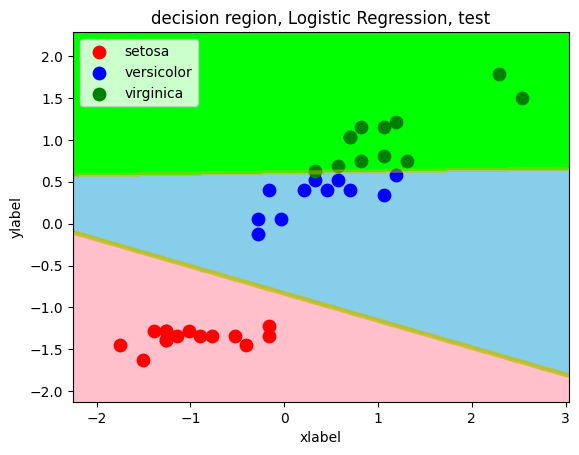

--- SVM ---
accuracy:  1.0
precision: 1.0
recall:    1.0
f1:        1.0
confusion matrix:
[[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]



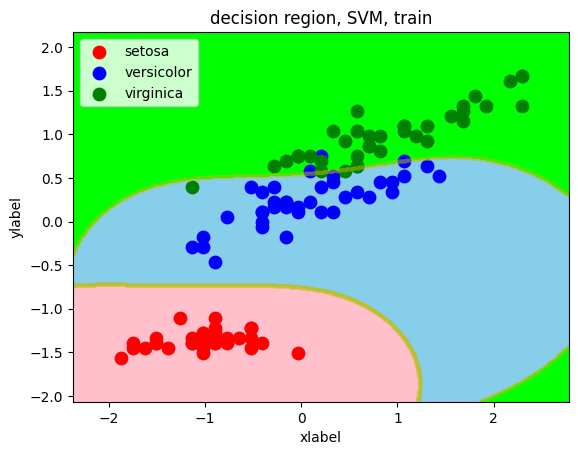

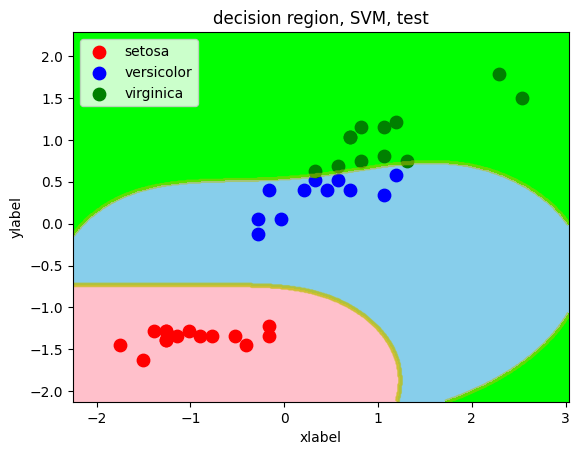

--- Decision Tree ---
accuracy:  0.9736842105263158
precision: 0.9722222222222222
recall:    0.9722222222222222
f1:        0.9710144927536232
confusion matrix:
[[15  0  0]
 [ 0 11  0]
 [ 0  1 11]]



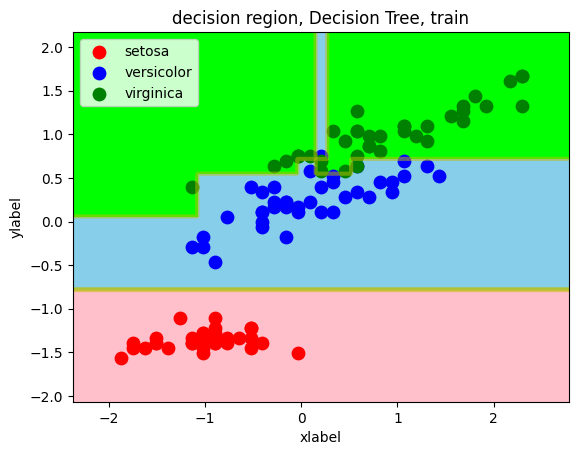

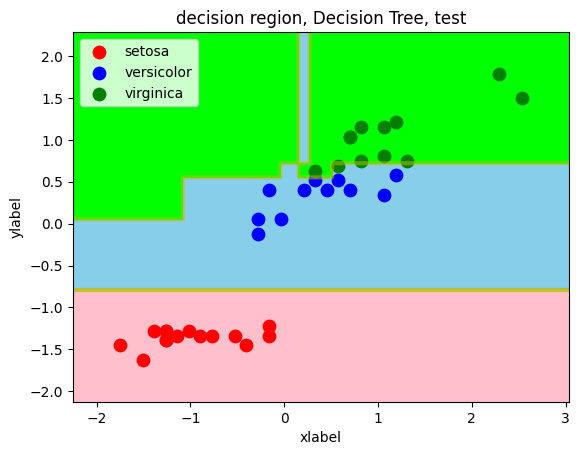

--- Random Forest ---
accuracy:  1.0
precision: 1.0
recall:    1.0
f1:        1.0
confusion matrix:
[[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]



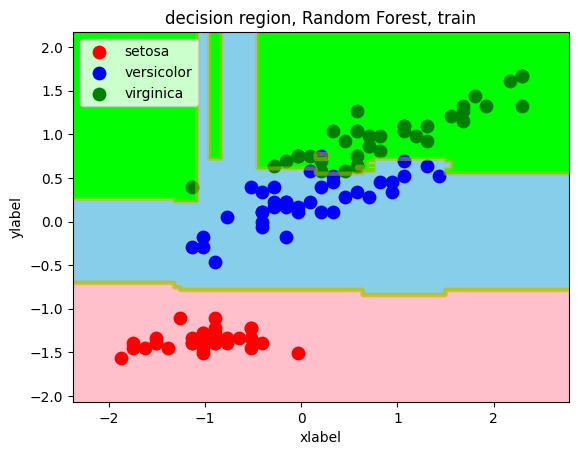

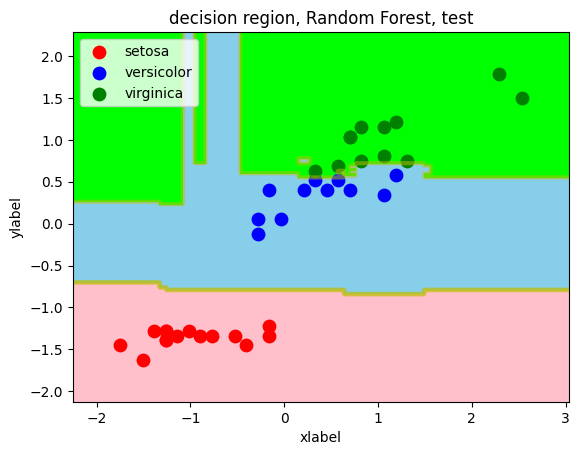

In [17]:
model_dict = {
    '1-nn': KNeighborsClassifier(n_neighbors=1),
    '3-nn': KNeighborsClassifier(n_neighbors=3),
    '5-nn': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

for key in model_dict.keys():
    model_dict[key].fit(X_train_scaled2, y_train2)
    y_pred = model_dict[key].predict(X_test_scaled2)
    
    evaluate2(y_test2, y_pred, key)
    decision_region2(X_train_scaled2, y_train2, model_dict[key], title=f'decision region, {key}, train')
    decision_region2(X_test_scaled2,  y_test2,  model_dict[key], title=f'decision region, {key}, test')